## Travis Klipp
## 823394891
## CS 696 HW 2

## The below cells describe how to generate the HDF5 files for both vaex and pandas.

In [3]:

###Loading libraries and specifying column names by exact case

import os 
import pandas as pd
#import dask
i#mport dask.dataframe as dd
import glob
from zipfile import ZipFile
import pylab as plt
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 500)
from matplotlib import pyplot
import vaex
from tqdm.notebook import tqdm


colms= ['Passenger_count','Trip_distance','Fare_amount',
'Total_amount','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude']




NameError: name 'i' is not defined

### I excluded all files in the zip file after 2016-06 as those files contain locationIDs instead of latitude/longitude. Didn't want to waste computational time and memory including those files in the zip folder.

In [9]:
# Set up the list of zip files to be opened and converted
zip_list = np.sort(np.array(glob.glob('C:/Users/travi/OneDrive/Desktop/green.zip')))[::-1]


# The output directory
output_dir = 'C:/Users/travi/OneDrive/Desktop/hdf5'
zip_file = ZipFile('C:/Users/travi/OneDrive/Desktop/green.zip')


### The cell below creates the hdf5 files for the vaex section.

In [82]:
# The magic happens heree:
for file in tqdm(zip_list, leave=False, desc='Converting to hdf5...'):
    # Setting up the files, and directories
    zip_file = ZipFile(file)
    output_file = file.split('/')[-1][:-3]+'hdf5'
    output = output_dir + output_file
    
    # Check if a converted file already exists: if it does skip it, otherwise read in the raw csv and convert it
    if (os.path.exists(output) and os.path.isfile(output)):
        pass
    else:
        # Importing the data into pandas 
        pandas_df = pd.concat([pd.read_csv(zip_file.open(text_file.filename), 
                                 encoding='latin',
                                 usecols=colms,
                                 skip_blank_lines=True,
                                 index_col=False,)
                     for text_file in zip_file.infolist()
                     if text_file.filename.endswith('.csv')])
        # Rename some columns to match the more well known dataset from 
        # http://stat-computing.org/dataexpo/2009/the-data.html
        #pandas_df.rename(columns=rename_dict, inplace=True)

        # Importing the data from pandas to vaex
        vaex_df = vaex.from_pandas(pandas_df, copy_index=False)
        
        # Export the data with vaex to hdf5
        vaex_df.export_hdf5(path=output, progress=False)

### The cell below creates the hdf5 file for the pandas/dask section.

In [ ]:
output_dir = 'C:/Users/travi/OneDrive/Desktop/'
# The magic happens heree:
for file in tqdm(zip_list, leave=False, desc='Converting to hdf5...'):
    # Setting up the files, and directories
    zip_file = ZipFile(file)
    output_file = file.split('/')[-1][:-3]+'hdf5'
    output = output_dir + output_file
    
    # Check if a converted file already exists: if it does skip it, otherwise read in the raw csv and convert it
    if (os.path.exists(output) and os.path.isfile(output)):
        pass
    else:
        # Importing the data into pandas 
        pandas_df = pd.concat([pd.read_csv(zip_file.open(text_file.filename), 
                                 encoding='latin',
                                 usecols=colms,
                                 skip_blank_lines=True,
                                 index_col=False,)
                     for text_file in zip_file.infolist()
                     if text_file.filename.endswith('.csv')])
        # Rename some columns to match the more well known dataset from 
        # http://stat-computing.org/dataexpo/2009/the-data.html
        #pandas_df.rename(columns=rename_dict, inplace=True)
        
        # Export the data with vaex to hdf5
        pandas_df.to_hdf(output,'data')

C:\Users\travi\anaconda3\lib\site-packages\tables\leaf.py:353: RuntimeWarning: overflow encountered in long_scalars
  expected_mb = (expectedrows * rowsize) // MB


### I created two different directories for the hdf5 files. For vaex, the hdf5 file is read from the below directory.

In [1]:
vaexdf=vaex.open('C:/Users/travi/OneDrive/Desktop/vaex/vaex.hdf5')


NameError: name 'vaex' is not defined

# Vaex Tasks

In [3]:
#For some reason the heatmap wouldn't generate unless I excluded some lat/long values that were separated from the rest

# Define the boundaries by interactively choosing the area of interest!
long_min = -120
long_max = -72
lat_min = 0
lat_max = 100

# Make a selection based on the boundaries
vaexdf = vaexdf[(vaexdf.Pickup_longitude > long_min)  & (vaexdf.Pickup_longitude < long_max) & \
                 (vaexdf.Pickup_latitude > lat_min)    & (vaexdf.Pickup_latitude < lat_max) & \
                 (vaexdf.Dropoff_longitude > long_min) & (vaexdf.Dropoff_longitude < long_max) & \
                 (vaexdf.Dropoff_latitude > lat_min)   & (vaexdf.Dropoff_latitude < lat_max)]

## Task 1) Distribution of number of passengers compared to unique trips
### 301ms for vaex to run the code to calculate the number of passengers

[################################--------] 100.00% elapsed time  :     0.43s =  0.0m =  0.0h
 

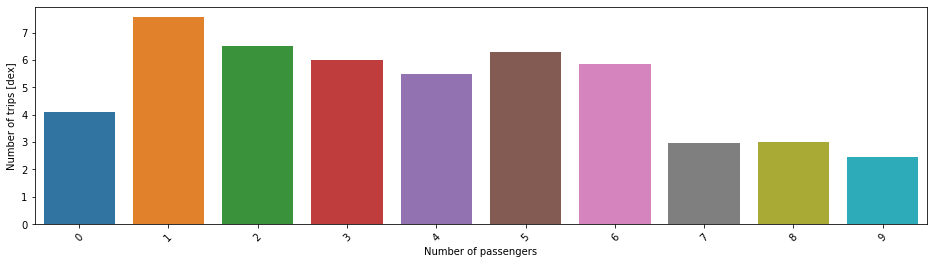

Wall time: 739 ms


In [156]:
%%time
# Get number of unique trips with certain number of passengers
num_passengers = vaexdf.Passenger_count.value_counts(progress=True)

# Plot the result
plt.figure(figsize=(16, 4))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

## Task 2) Filtering out trips with passengers greater than 10 and distance greater than 100
### 28.9 ms to run

In [4]:
%%time
# Filterd based on the number of passengers
vaexdf = vaexdf[(vaexdf.Passenger_count<10) & (vaexdf.Trip_distance<100)]

Wall time: 45 ms


## Task 3) Produce a heat map by pick up location color coded by average fare amount
### 1.09 seconds to run

Wall time: 1.09 s


Text(95.5, 0.5, 'pickup latitude')

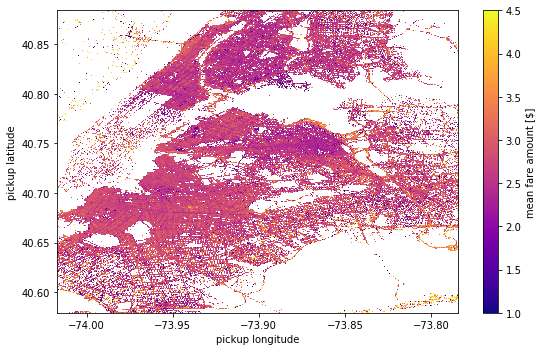

In [160]:
%%time
plt.figure(figsize=(15, 5))

plt.subplot(121)
vaexdf.plot('Pickup_longitude', 'Pickup_latitude', what='mean(Fare_amount)',
                 colormap='plasma', f='log1p', shape=512, colorbar=True, 
                 colorbar_label='mean fare amount [$]', vmin=1, vmax=4.5)

plt.xlabel('pickup longitude')
plt.ylabel('pickup latitude')


## Task 4)Compute the arc distance for the filtered data and plot the distribution number of trips of tripdistance and arc distance.
### 3.88 seconds


In [2]:
# arc distance function
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8


[###############################---------] 100.00% elapsed time  :     0.82s =  0.0m =  0.0h
[#######################################-] 100.00% elapsed time  :     2.10s =  0.0m =  0.0h
 

C:\Users\travi\anaconda3\lib\site-packages\vaex\viz\mpl.py:128: RuntimeWarning: divide by zero encountered in log10
  fgrid = f(grid)


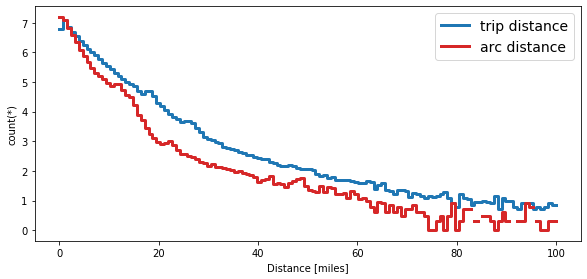

Wall time: 3.88 s


In [163]:
%%time
# Expression to be pre-compiled with numba, and then executed
df_filtered['arc_distance'] = arc_distance(df_filtered.Pickup_longitude, 
                                           df_filtered.Pickup_latitude, 
                                           df_filtered.Dropoff_longitude, 
                                           df_filtered.Dropoff_latitude).jit_numba()


plt.figure(figsize=(16, 4))

plt.subplot(121)
df_filtered.plot1d('Trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   label='trip distance', progress=True)
df_filtered.plot1d('arc_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C3', 
                   label='arc distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')





plt.show()

In [ ]:
#Delete the vaexdf to free space
del vaexdf

# Pandas Tasks

In [170]:
#The pandas dataframe takes more time to load compared to vaex.

pandasdf=pd.read_hdf('C:/Users/travi/OneDrive/Desktop/pandas/green.hdf5')

#Also added boundaries to be consistent for each approach

# Define the boundaries by interactively choosing the area of interest!
long_min = -120
long_max = -72
lat_min = 0
lat_max = 100

# Make a selection based on the boundaries
pandasdf = pandasdf[(pandasdf.Pickup_longitude > long_min)  & (pandasdf.Pickup_longitude < long_max) & \
                 (pandasdf.Pickup_latitude > lat_min)    & (pandasdf.Pickup_latitude < lat_max) & \
                 (pandasdf.Dropoff_longitude > long_min) & (pandasdf.Dropoff_longitude < long_max) & \
                 (pandasdf.Dropoff_latitude > lat_min)   & (pandasdf.Dropoff_latitude < lat_max)]

## Task 1) Distribution of number of passengers compared to unique trips
### 1.45 seconds, which is a full second slower than vaex.

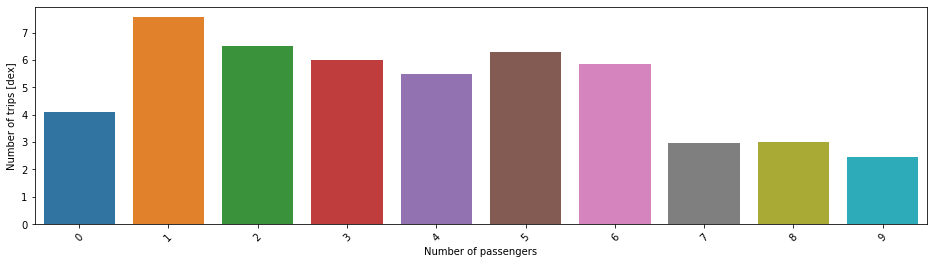

Wall time: 1.46 s


In [172]:
%%time
# Get number of unique trips with certain number of passengers
num_passengers = pandasdf.Passenger_count.value_counts()

# Plot the result
plt.figure(figsize=(16, 4))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

## Task 2) Filtering out trips with passengers greater than 10 and distance greater than 100
### 5.76 seconds which is significantly slower than vaex.

In [174]:
%%time
# Filtered based on the number of passengers
pandasdf = pandasdf[(pandasdf.Passenger_count<10) & (pandasdf.Trip_distance<100)]

Wall time: 5.76 s


## Task 3) Produce a heat map by pick up location color coded by average fare amount
### 3.43 seconds using seaborn package. This is 2 seconds slower than vaex, but uses a different method and also had to round decimal places, so it's not completely consistent with the vaex approach. Either way, there is a noticable lag, which is significant and shows the slowness of pandas.

In [ ]:
#### The approach was to create a pivot table, as the method used for vaex wasn't exactly replicable in pandas.

In [175]:
# Create a temporary dataframe with the columns needed
heat=pandasdf[['Pickup_longitude','Pickup_latitude','Fare_amount']]


In [176]:
#The pivot table would not load due to the amount of unique latitude and longitude values.
#To overcome this issue, I rounded to 3 decimal places.
heat['Pickup_longitude']=heat.Pickup_longitude.round(3)
heat['Pickup_latitude']=heat.Pickup_latitude.round(3)

C:\Users\travi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\travi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [177]:
#Take the log1p value of the fare amount to be consistent with the  vaex code.
heat['Log_Fare_amount']=np.log1p(heat.Fare_amount)

C:\Users\travi\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\travi\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\travi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [178]:
#Create pivot table which will be used to create the heatmap. 
heat=heat.pivot_table(index="Pickup_latitude",columns="Pickup_longitude",values="Log_Fare_amount",aggfunc="mean")

Wall time: 3.43 s


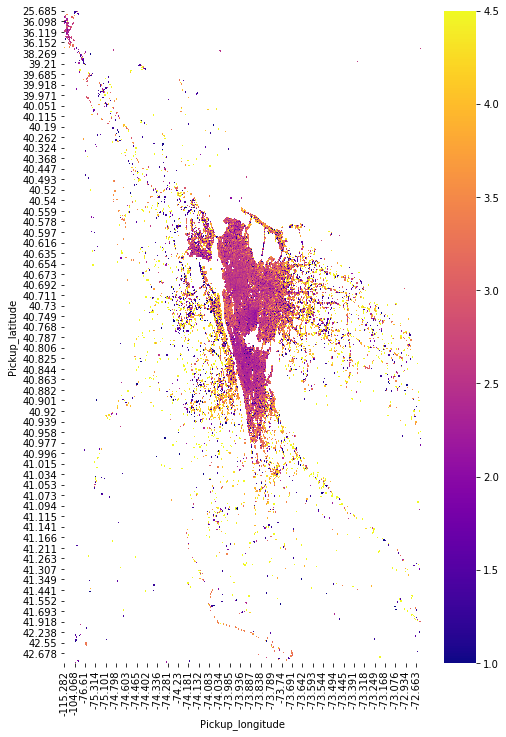

In [180]:
%%time
#Generate heatmap using seaborn
plt.figure(figsize=(8, 12))
sns.heatmap(heat, cmap="plasma", vmin = 1, vmax = 4.5)

In [181]:
# Delete temp dataframe
del heat

## Task 4)Compute the arc distance for the filtered data and plot the distribution number of trips of tripdistance and arc distance.
### 17.8 seconds. Even when using a different method to plotting the distributions for the trip distance and arc distance, it takes a signifant amount of more time to calculate the arc distances and plots compared to vaex.

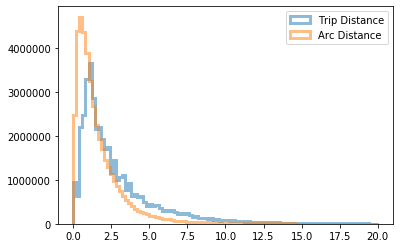

Wall time: 17.8 s


In [188]:
%%time
# Expression to be pre-compiled with numba, and then executed
pandasdf['arc_distance'] = arc_distance(pandasdf.Pickup_longitude, 
                                           pandasdf.Pickup_latitude, 
                                           pandasdf.Dropoff_longitude, 
                                           pandasdf.Dropoff_latitude)

# Used pyplot, code from vaex wasn't exactly replicable using pandas.
pyplot.hist(pandasdf['Trip_distance'], bins=100, alpha=0.5, label='Trip Distance',range=[0,20],histtype=u'step',lw=3)
pyplot.hist(pandasdf['arc_distance'], bins=100, alpha=0.5, label='Arc Distance',range=[0,20],histtype=u'step',lw=3)
pyplot.legend(loc='upper right')
pyplot.show()


# Dask Tasks

In [3]:
pandasdf=pd.read_hdf('C:/Users/travi/OneDrive/Desktop/pandas/green.hdf5')

#utilized random number of partitions, maybe faster with more partitions. Slow to read from pandas dataframe.
daskdf=dd.from_pandas(pandasdf,npartitions=20)


In [12]:
del pandasdf


In [4]:
# Define the boundaries by interactively choosing the area of interest!
long_min = -120
long_max = -72
lat_min = 0
lat_max = 100

# Make a selection based on the boundaries
daskdf = daskdf[(daskdf.Pickup_longitude > long_min)  & (daskdf.Pickup_longitude < long_max) & \
                 (daskdf.Pickup_latitude > lat_min)    & (daskdf.Pickup_latitude < lat_max) & \
                 (daskdf.Dropoff_longitude > long_min) & (daskdf.Dropoff_longitude < long_max) & \
                 (daskdf.Dropoff_latitude > lat_min)   & (daskdf.Dropoff_latitude < lat_max)]

## Task 1) Distribution of number of passengers compared to unique trips
### If I don't filter out based on the above boundaries, it only takes 713 ms to generate. However, if I select based on the boundaries above (to be consistent with vask and pandas), it takes 5.65 seconds to generate.

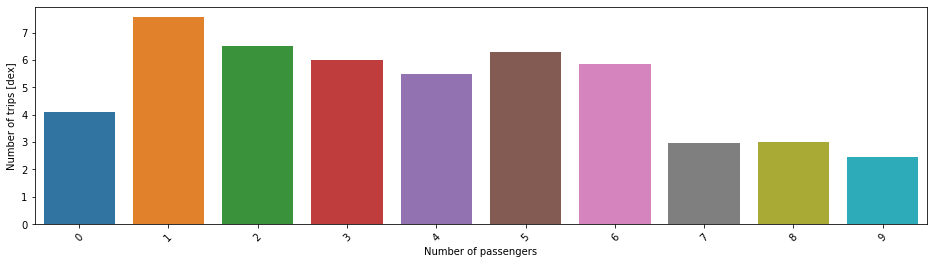

Wall time: 5.65 s


In [8]:
%%time
# Get number of unique trips with certain number of passengers
num_passengers = daskdf.Passenger_count.value_counts().compute()
# Plot the result
plt.figure(figsize=(16, 4))
sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()


## Task 2) Filtering out trips with passengers greater than 10 and distance greater than 100
### Takes 4.99 ms, which is very fast compared to pandas and slightly faster than vaex.

In [15]:
%%time
daskdf = daskdf[(daskdf.Passenger_count<10) & (daskdf.Trip_distance<100)]

## Task 3) Produce a heat map by pick up location color coded by average fare amount
### Tried replicating same process as pandas but due to restrictions with pivot table was unable to compile in a satisfactory time.

In [219]:
heat=daskdf[['Pickup_longitude','Pickup_latitude','Fare_amount']]

In [220]:
heat['Log_Fare_amount']=np.log1p(heat.Fare_amount)
#The pivot table would not load due to the amount of unique latitude and longitude values.
#To overcome this issue, I rounded to 3 decimal places.
heat['Pickup_longitude']=heat.Pickup_longitude.round(3)
heat['Pickup_latitude']=heat.Pickup_latitude.round(3)
#Take the log1p value of the fare amount to be consistent with the  vaex code.
heat['Log_Fare_amount']=np.log1p(heat.Fare_amount)
heat=heat.categorize('Pickup_longitude')
#Create pivot table which will be used to create the heatmap. 
heat=heat.pivot_table(index="Pickup_latitude",columns="Pickup_longitude",values="Log_Fare_amount",aggfunc="mean")
#Generate heatmap using seaborn
plt.figure(figsize=(8, 12))
sns.heatmap(heat, cmap="plasma", vmin = 1, vmax = 4.5)

C:\Users\travi\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\travi\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
del heat

## Task 4)Compute the arc distance for the filtered data and plot the distribution number of trips of tripdistance and arc distance.
### 47.8 seconds. This is very slow compared to pandas, but perhaps with more partitions there would be an improvement in computational speed and performance.

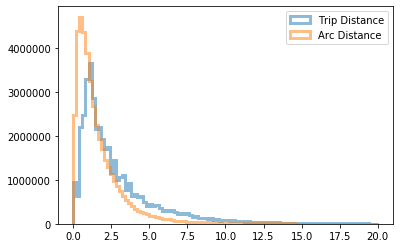

Wall time: 47.8 s


In [16]:
%%time
# Expression to be pre-compiled with numba, and then executed
daskdf['arc_distance'] = arc_distance(daskdf.Pickup_longitude, 
                                           daskdf.Pickup_latitude, 
                                           daskdf.Dropoff_longitude, 
                                           daskdf.Dropoff_latitude)

daskdf=daskdf.compute()
# Used pyplot, code from vaex wasn't exactly replicable using pandas.
pyplot.hist(daskdf['Trip_distance'], bins=100, alpha=0.5, label='Trip Distance',range=[0,20],histtype=u'step',lw=3)
pyplot.hist(daskdf['arc_distance'], bins=100, alpha=0.5, label='Arc Distance',range=[0,20],histtype=u'step',lw=3)
pyplot.legend(loc='upper right')
pyplot.show()

In [17]:
del daskdf

# Discussion
Overall, vaex greatly out-performed dask and pandas. The only task that vaex was slower was filtering out the data, which was only by milliseconds compared to dask. Vaex has quite a few capabilities when it comes to plotting and computation, though it's not as straight-forward and versatile as pandas.
Pandas was computationally slower than vaex, modifications were made so the tasks could be completed. Pandas is clearly not made to handle very large datasets but can perform well with smaller computations and plotting. There were issues replicating the code from vaex to pandas so the approach isn't the same (which makes it tough to make a side-by-side comparison), but there were clear performance issues compared to vaex. 
Dask performed well at certain computations but there were issues with plotting. Dask may have better performance depending on the number of partitions or chunks, it performed extremely slowly for tasks 3 and 4 (and even timed out for smaller partitions). Dask performed very well filtering out the data; this suggests that dask can be optimal for certain computational tasks compared to pandas/vaex.

In [6]:
daskdf.head()

,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Total_amount
0,-73.930580,40.695179,-74.000053,40.729046,1,5.24,19.5,27.04
0,-73.878700,40.881329,-73.838387,40.884838,1,2.64,10.5,11.80
0,-73.955620,40.680756,-73.961456,40.666138,1,1.18,6.0,7.30
0,-73.944756,40.819050,-73.949486,40.812614,1,0.49,3.5,4.80
0,-73.865013,40.826099,-73.864990,40.826099,1,0.00,7.0,7.00
